In [1]:
from __future__ import print_function, division
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
from torchvision import transforms

import tqdm
import time
import copy
import numpy as np

import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader, ConcatDataset

import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
torch.cuda.random.manual_seed(0)
torch.random.manual_seed(0)
np.random.seed(0)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
BATCH_SIZE = 256
EPOCH = 30
LR = 0.01
SAVE_IN = '/content/drive/MyDrive/Models/best_model_wts_v02'

# Data Preparation

In [6]:
train_dataset = datasets.MNIST(
        root='data', train=True, download=True,
        transform= transforms.ToTensor())

test_dataset = datasets.MNIST(
        root='data', train=False, download=True,
        transform= transforms.ToTensor())

transformers = transforms.Compose([
        transforms.RandomAffine(degrees = 30),
        transforms.RandomPerspective(),
        transforms.ToTensor()])

train_dataset_transformed = datasets.MNIST(root='data', train=True, download=True, transform=transformers)

In [7]:
final_dataset = ConcatDataset([train_dataset, train_dataset_transformed])

In [8]:
test_dataset, valid_subset = torch.utils.data.random_split(
        test_dataset, [5_000, 5_000], generator=torch.Generator())

In [9]:
train_loader = DataLoader(
        dataset=final_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_loader = DataLoader(
        dataset=valid_subset, batch_size=BATCH_SIZE, shuffle=False)

test_loader = DataLoader(
        dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
data = next(iter(train_loader))
data[0].shape

torch.Size([256, 1, 28, 28])

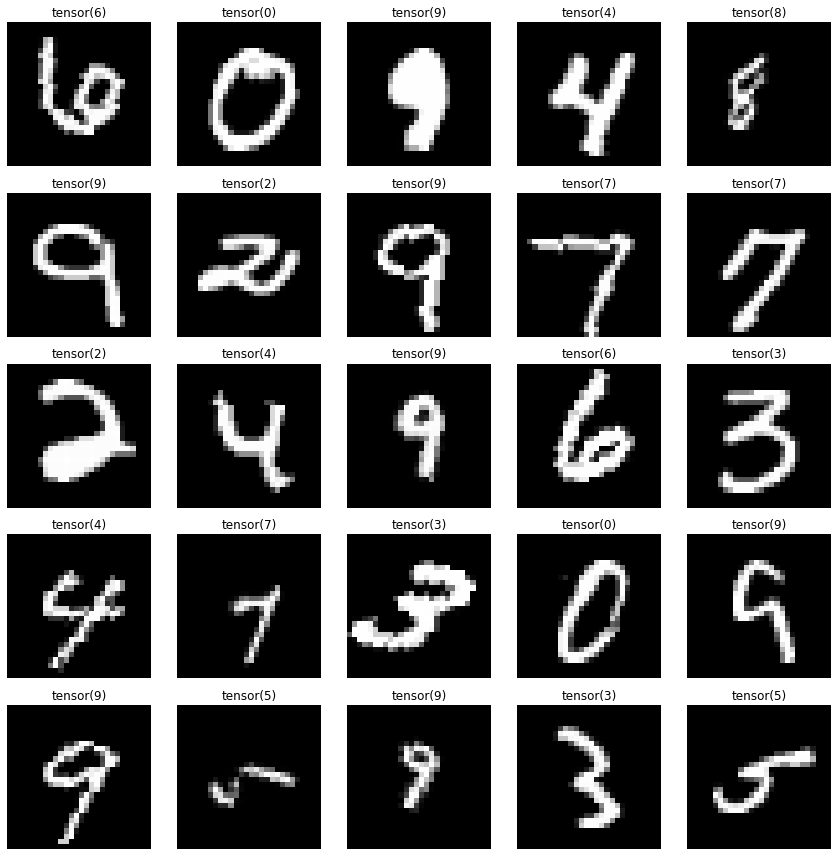

In [11]:
import matplotlib.pyplot as plt

n = 5
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n ** 2):
    ax = axs[i // n, i % n]
    ax.imshow(data[0][i].squeeze(), cmap=plt.cm.gray)
    ax.set_title(data[1][i])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [12]:
dataloaders_dict = {'train': train_loader, 'val': valid_loader}
dataset_sizes_dict = {'train': len(final_dataset), 'val': len(valid_subset)}

# Definitions

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

net = CNN().to(device)

In [14]:
net(data[0].to(device)).shape

torch.Size([256, 10])

In [15]:
def train_model(model, criterion, optimizer, scheduler, attack, dataloaders, dataset_sizes, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:

            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm.tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                if attack:
                    _, inputs = attack(inputs, labels)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('epoch:{} phase:{}'.format(epoch + 1, phase))
            print(
                '{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, SAVE_IN)

    time_elapsed = time.time() - since

    print(
        'Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print(
        'Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)

    return model

In [16]:
criterion_md = nn.CrossEntropyLoss()

optimizer_md = optim.Adam(net.parameters(), lr=LR)

lr_scheduler_md = lr_scheduler.StepLR(optimizer_md, step_size=10, gamma=0.1)

In [17]:
class RSAttack:

    def __init__(
            self,
            predict,
            n_queries=5000,
            eps=None,
            p_init=.8,
            n_restarts=1,
            verbose=True,
            targeted=False,
            loss='margin',
            resc_schedule=True,
            device=None,
            constant_schedule=False):

        self.ndims = None
        self.predict = predict
        self.n_queries = n_queries
        self.eps = eps
        self.p_init = p_init
        self.n_restarts = n_restarts
        self.verbose = verbose
        self.targeted = targeted
        self.loss = loss
        self.rescale_schedule = resc_schedule
        self.device = device
        self.constant_schedule = constant_schedule

    def margin_and_loss(self, x, y):

        logits = self.predict(x)

        xent = F.cross_entropy(logits, y, reduction='none')
        u = torch.arange(x.shape[0])
        y_corr = logits[u, y].clone()
        logits[u, y] = -float('inf')
        y_others = logits.max(dim=-1)[0]

        if not self.targeted:
            if self.loss == 'ce':
                return y_corr - y_others, -1. * xent
            elif self.loss == 'margin':
                return y_corr - y_others, y_corr - y_others
        else:
            return y_others - y_corr, xent

    def init_hyperparameters(self, x):

        assert not self.eps is None
        assert self.loss in ['ce', 'margin']

        if self.device is None:
            self.device = x.device

        self.orig_dim = list(x.shape[1:])
        self.ndims = len(self.orig_dim)

        if self.targeted:
            self.loss = 'ce'

    def random_target_classes(self, y_pred, n_classes):
        y = torch.zeros_like(y_pred)
        for counter in range(y_pred.shape[0]):
            l = list(range(n_classes))
            l.remove(y_pred[counter])
            t = self.random_int(0, len(l))
            y[counter] = l[t]

        return y.long().to(self.device)

    def check_shape(self, x):
        return x if len(x.shape) == self.ndims + 1 else x.unsqueeze(0)

    def random_choice(self, shape):
        t = 2 * torch.rand(shape).to(self.device) - 1
        return torch.sign(t)

    def random_int(self, low=0, high=1, shape=None):
        if shape is None:
            shape = [1]

        t = low + (high - low) * torch.rand(shape).to(self.device)
        return t.long()

    def p_selection(self, it):
        """ schedule to decrease the parameter p """

        if self.rescale_schedule:
            it = int(it / self.n_queries * 10000)

        if 0 < it <= 50:
            p = self.p_init / 2
        elif 50 < it <= 200:
            p = self.p_init / 4
        elif 200 < it <= 500:
            p = self.p_init / 5
        elif 500 < it <= 1000:
            p = self.p_init / 6
        elif 1000 < it <= 2000:
            p = self.p_init / 8
        elif 2000 < it <= 4000:
            p = self.p_init / 10
        elif 4000 < it <= 6000:
            p = self.p_init / 12
        elif 6000 < it <= 8000:
            p = self.p_init / 15
        elif 8000 < it:
            p = self.p_init / 20
        else:
            p = self.p_init

        if self.constant_schedule:
            p = self.p_init / 2

        return p

    def attack_single_run(self, x, y):
        with torch.no_grad():

            c, h, w = x.shape[1:]
            n_ex_total = x.shape[0]

            eps = self.eps

            x_best = x.clone()
            n_pixels = h * w
            b_all, be_all = torch.zeros([x.shape[0], eps]).long(), torch.zeros([x.shape[0], n_pixels - eps]).long()
            for img in range(x.shape[0]):
                ind_all = torch.randperm(n_pixels)
                ind_p = ind_all[:eps]
                ind_np = ind_all[eps:]

                x_best[img, :, ind_p // w, ind_p % w] = self.random_choice([c, eps]).clamp(0., 1.)

                b_all[img] = ind_p.clone()
                be_all[img] = ind_np.clone()

            margin_min, loss_min = self.margin_and_loss(x_best, y)
            n_queries = torch.ones(x.shape[0]).to(self.device)

            for it in range(1, self.n_queries):
                # check points still to fool

                idx_to_fool = (margin_min > 0.).nonzero().squeeze()
                x_curr = self.check_shape(x[idx_to_fool])
                x_best_curr = self.check_shape(x_best[idx_to_fool])
                y_curr = y[idx_to_fool]
                margin_min_curr = margin_min[idx_to_fool]
                loss_min_curr = loss_min[idx_to_fool]
                b_curr, be_curr = b_all[idx_to_fool], be_all[idx_to_fool]

                if len(y_curr.shape) == 0:
                    y_curr.unsqueeze_(0)
                    margin_min_curr.unsqueeze_(0)
                    loss_min_curr.unsqueeze_(0)
                    b_curr.unsqueeze_(0)
                    be_curr.unsqueeze_(0)
                    idx_to_fool.unsqueeze_(0)

                # build new candidate
                x_new = x_best_curr.clone()
                eps_it = max(int(self.p_selection(it) * eps), 1)
                ind_p = torch.randperm(eps)[:eps_it]
                ind_np = torch.randperm(n_pixels - eps)[:eps_it]

                for img in range(x_new.shape[0]):
                    p_set = b_curr[img, ind_p]
                    np_set = be_curr[img, ind_np]
                    x_new[img, :, p_set // w, p_set % w] = x_curr[img, :, p_set // w, p_set % w].clone()

                    if eps_it > 1:
                        x_new[img, :, np_set // w, np_set % w] = self.random_choice([c, eps_it]).clamp(0., 1.)
                    else:
                        # if update is 1x1 make sure the sampled color is different from the current one
                        old_clr = x_new[img, :, np_set // w, np_set % w].clone()
                        assert old_clr.shape == (c, 1), print(old_clr)
                        new_clr = old_clr.clone()
                        while (new_clr == old_clr).all().item():
                            new_clr = self.random_choice([c, 1]).clone().clamp(0., 1.)
                        x_new[img, :, np_set // w, np_set % w] = new_clr.clone()

                # compute loss of the new candidates
                margin, loss = self.margin_and_loss(x_new, y_curr)
                n_queries[idx_to_fool] += 1

                # update best solution
                idx_improved = (loss < loss_min_curr).float()
                idx_to_update = (idx_improved > 0.).nonzero().squeeze()
                loss_min[idx_to_fool[idx_to_update]] = loss[idx_to_update]

                idx_miscl = (margin < -1e-6).float()
                idx_improved = torch.max(idx_improved, idx_miscl)
                nimpr = idx_improved.sum().item()
                if nimpr > 0.:
                    idx_improved = (idx_improved.view(-1) > 0).nonzero().squeeze()
                    margin_min[idx_to_fool[idx_improved]] = margin[idx_improved].clone()
                    x_best[idx_to_fool[idx_improved]] = x_new[idx_improved].clone()
                    t = b_curr[idx_improved].clone()
                    te = be_curr[idx_improved].clone()

                    if nimpr > 1:
                        t[:, ind_p] = be_curr[idx_improved][:, ind_np] + 0
                        te[:, ind_np] = b_curr[idx_improved][:, ind_p] + 0
                    else:
                        t[ind_p] = be_curr[idx_improved][ind_np] + 0
                        te[ind_np] = b_curr[idx_improved][ind_p] + 0

                    b_all[idx_to_fool[idx_improved]] = t.clone()
                    be_all[idx_to_fool[idx_improved]] = te.clone()

                # log results current iteration
                ind_succ = (margin_min <= 0.).nonzero().squeeze()
                if self.verbose and ind_succ.numel() != 0:
                    print(' '.join(['{}'.format(it + 1),
                       '- success rate={}/{} ({:.2%})'.format(
                           ind_succ.numel(), n_ex_total,
                           float(ind_succ.numel()) / n_ex_total),
                       '- avg # queries={:.1f}'.format(
                           n_queries[ind_succ].mean().item()),
                       '- med # queries={:.1f}'.format(
                           n_queries[ind_succ].median().item()),
                       '- loss={:.3f}'.format(loss_min.mean()),
                       '- max pert={:.0f}'.format(((x_new - x_curr).abs() > 0).max(1)[0].view(x_new.shape[0], -1).sum(-1).max()),
                       '- epsit={:.0f}'.format(eps_it),
                       ]))

                if ind_succ.numel() == n_ex_total:
                    break

        return n_queries, x_best

    def perturb(self, x, y=None):

        self.init_hyperparameters(x)

        adv = x.clone()
        qr = torch.zeros([x.shape[0]]).to(self.device)

        if y is None:
            if not self.targeted:
                with torch.no_grad():
                    output = self.predict(x)
                    y_pred = output.max(1)[1]
                    y = y_pred.detach().clone().long().to(self.device)
            else:
                with torch.no_grad():
                    output = self.predict(x)
                    n_classes = output.shape[-1]
                    y_pred = output.max(1)[1]
                    y = self.random_target_classes(y_pred, n_classes)
        else:
            y = y.detach().clone().long().to(self.device)

        if not self.targeted:
            acc = self.predict(x).max(1)[1] == y
        else:
            acc = self.predict(x).max(1)[1] != y

        startt = time.time()

        for counter in range(self.n_restarts):
            ind_to_fool = acc.nonzero().squeeze()
            if len(ind_to_fool.shape) == 0:
                ind_to_fool = ind_to_fool.unsqueeze(0)

            if ind_to_fool.numel() != 0:
                x_to_fool = x[ind_to_fool].clone()
                y_to_fool = y[ind_to_fool].clone()

                qr_curr, adv_curr = self.attack_single_run(x_to_fool, y_to_fool)

                output_curr = self.predict(adv_curr)
                if not self.targeted:
                    acc_curr = output_curr.max(1)[1] == y_to_fool
                else:
                    acc_curr = output_curr.max(1)[1] != y_to_fool
                ind_curr = (acc_curr == 0).nonzero().squeeze()

                acc[ind_to_fool[ind_curr]] = 0
                adv[ind_to_fool[ind_curr]] = adv_curr[ind_curr].clone()
                qr[ind_to_fool[ind_curr]] = qr_curr[ind_curr].clone()

                if self.verbose:
                    print('restart {} - robust accuracy: {:.2%}'.format(
                        counter, acc.float().mean()),
                        '- cum. time: {:.1f} s'.format(
                            time.time() - startt))

        return qr, adv


In [22]:
adversary = RSAttack(net, eps=40, verbose=False, n_queries=200, loss='ce', device=device)

In [23]:
data = next(iter(train_loader))
data[0].shape

torch.Size([256, 1, 28, 28])

In [20]:
# import matplotlib.pyplot as plt

# qs, adv_examples = adversary.perturb(data[0].to(device), data[1].to(device))
# advs = adv_examples.cpu()

# n = 6
# fig, axs = plt.subplots(
#    nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))

# for i in range(n ** 2 // 2):

#     ax = axs[(i * 2) // n, (i * 2) % n]
#     ax.imshow(data[0][i].squeeze(), cmap=plt.cm.gray)
#     ax.set_title(data[1][i])
#     ax.axis('off')

#     ax = axs[(i * 2 + 1) // n, (i * 2 + 1) % n]
#     ax.imshow(advs[i].squeeze(), cmap=plt.cm.gray)
#     ax.set_title(data[1][i])
#     ax.axis('off')

# plt.tight_layout()
# plt.show()

In [ ]:
# train normal
model_fn = train_model(
        net, criterion_md, optimizer_md, lr_scheduler_md, adversary.perturb,
        dataloaders_dict, dataset_sizes_dict, num_epochs=EPOCH)

 21%|██▏       | 100/469 [19:33<1:17:58, 12.68s/it]

# Prediction

In [ ]:
def predict(classifier, dataloader):

    test_pred = torch.LongTensor()
    classifier.eval()

    with torch.no_grad():

        for images in dataloader:

            images = torch.autograd.Variable(images[0])
            if torch.cuda.is_available():
                images = images.to(device)

            outputs = classifier(images)
            predicted = outputs.cpu().data.max(1, keepdim=True)[1]
            test_pred = torch.cat((test_pred, predicted), dim=0)

    return test_pred

In [ ]:
net = AlexNet().to(device)
net.load_state_dict(torch.load(SAVE_IN))

In [ ]:
results = predict(net, test_loader)

In [ ]:
import matplotlib.pyplot as plt

n = 5
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n ** 2):
    ax = axs[i // n, i % n]
    ax.imshow(test_dataset[i][0][0], cmap=plt.cm.gray)
    ax.set_title(results[i])
    ax.axis('off')

plt.tight_layout()
plt.show()